**Scenario: Smart Email Responder**

Build an AI that routes emails intelligently based on content.

**Flow:**

LLM analyzes email intent (question/complaint/feedback/spam)
LLM determines urgency (high/medium/low)

**Conditional routing:**

- Spam → Auto-delete
- Complaint + High urgency → Apologetic response (LLM)
- Question + Technical → Detailed answer (LLM with RAG)
- Feedback → Thank you note (LLM)
- Low urgency → Queue for later


In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional, Any, Literal
from dotenv import load_dotenv
from utils import AWSLLM

In [15]:
class SmartEmailState(TypedDict):
    email_text: str
    intent: Optional[Literal['Question', 'Complaint', 'Feedback', 'Spam']]
    urgency: Optional[Literal['High', 'Medium', 'Low']]
    status: Optional[str]
    is_technical: bool
    retrieved_context: Optional[str]
    response: str

In [34]:
def intent_classifier(state: SmartEmailState):
    pass

def urgency_classifier(state: SmartEmailState):
    pass

def router(state: SmartEmailState):
    pass

def technical_detection(state: SmartEmailState):
    pass

def apology_response(state: SmartEmailState):
    pass

def rag_answer(state: SmartEmailState):
    pass

def llm_response(state: SmartEmailState):
    pass

def feedback_response(state: SmartEmailState):
    pass

def queue(state: SmartEmailState):
    pass

def delete(state: SmartEmailState):
    pass

def is_spam(state: SmartEmailState):
    intent = state['intent']

    if intent.lower() == 'spam':
        return True
    else:
        return False

def check_status(state: SmartEmailState):
    intent = state["intent"]
    urgency = state["urgency"]

    if intent == "Question":
        return "question"

    if intent == "Complaint" and urgency == "High":
        return "apology_response"

    if intent == "Complaint" and urgency != "High":
        return "queue"

    if intent == "Feedback":
        return "feedback"


In [35]:
graph = StateGraph(SmartEmailState)

graph.add_node('intent_classifier', intent_classifier)
graph.add_node('urgency_classifier', urgency_classifier)
graph.add_node('delete', delete)
graph.add_node('router', router)
graph.add_node('technical_detection', technical_detection)
graph.add_node('rag_answer', rag_answer)
graph.add_node('llm_response', llm_response)
graph.add_node('apology_response', apology_response)
graph.add_node('feedback_response', feedback_response)
graph.add_node('queue', queue)


In [36]:
# edges
graph.add_edge(START, 'intent_classifier')
graph.add_edge(START, 'urgency_classifier')

graph.add_conditional_edges(
    "intent_classifier",
    is_spam,
    {
        True: "delete",
        False: "router"
    }
)

graph.add_edge('urgency_classifier', 'router')
graph.add_conditional_edges(
    "router",
    check_status,
    {
        'question': 'technical_detection',
        'apology_response': 'apology_response',
        'feedback': 'feedback_response',
        'queue': 'queue'
    }
)

graph.add_conditional_edges(
    'technical_detection',
    technical_detection,
    {
        True: 'rag_answer',
        False: 'llm_response'
    }
)
graph.add_edge('rag_answer', END)
graph.add_edge('llm_response', END)
graph.add_edge('apology_response', END)
graph.add_edge('feedback_response', END)
graph.add_edge('queue', END)


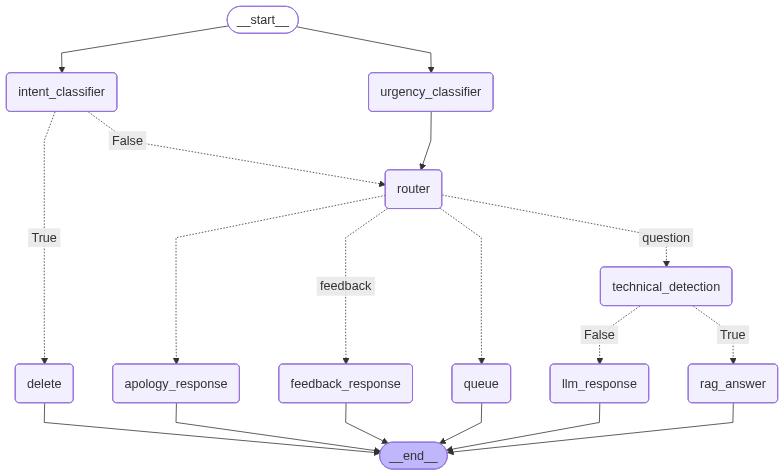

In [37]:
workflow = graph.compile()
workflow